

Mean = %4.3f
 0.0039961257177634196
Std. deviation = %4.3f
 0.041031528620959316
Skewness = %4.3f
 -0.27972693402031196
Excess kurtosis = %4.3f
 5.338455570833892


2.1887947522962334
1.6348491752445247
2.2707137992622877
1.6161226675659621


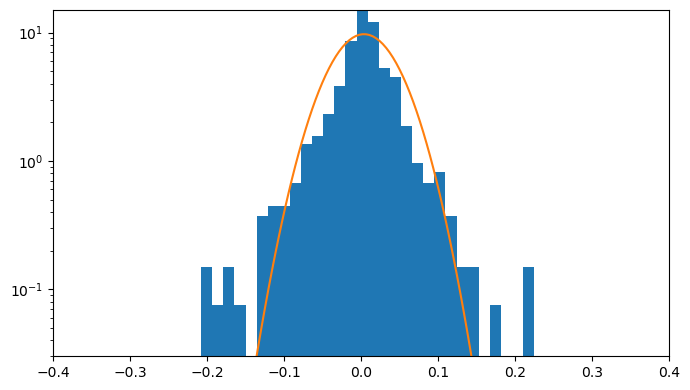

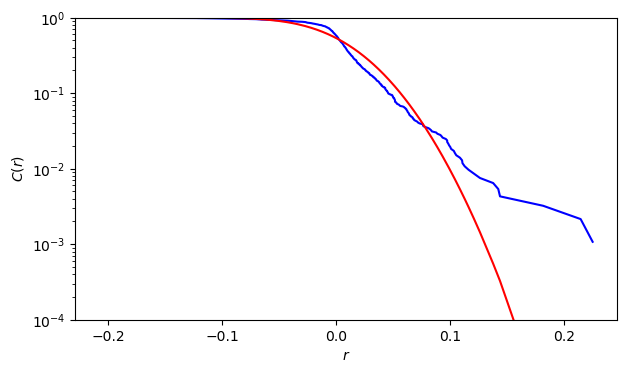

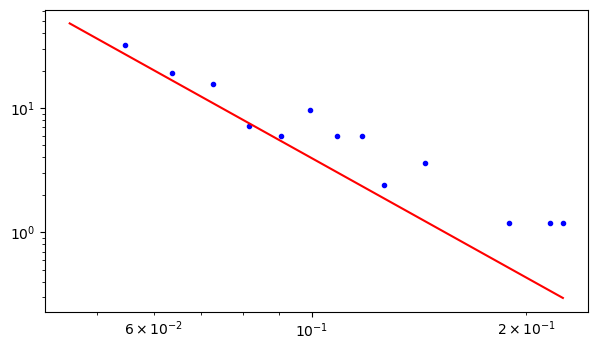

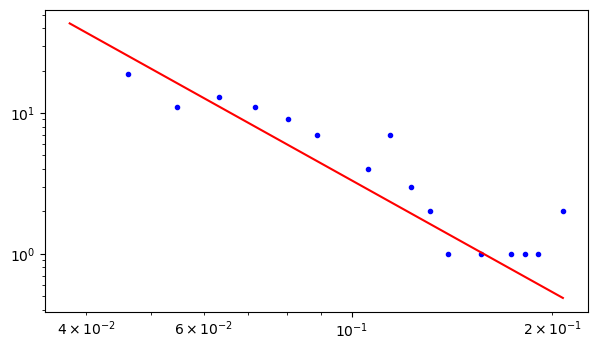

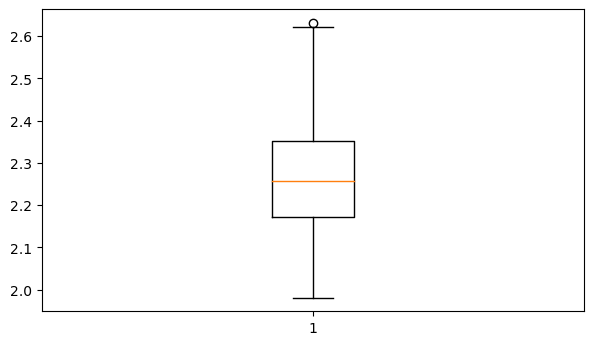

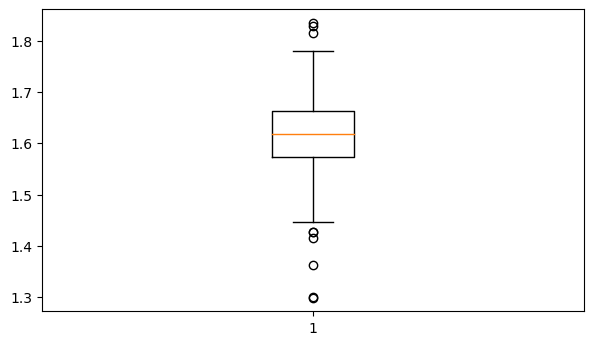

In [73]:
#!/usr/bin/python3.7
#Case_Study1.py
#Parth Parakh
#purpose: Maximum Likelihood on Crypocurrency Data
#---------------------------------------------------------------------
#import modules
import numpy as np
import csv
from scipy import special
import matplotlib.pyplot as plt
#----------------------------------------------------------------------
#helper function
def readFile(fileName):
    with open(fileName) as f:
        reader = csv.reader(f, delimiter="\t")
        d = list(reader)
    return d
        
if __name__ == '__main__':
    file = readFile("cryptocurrency_prices.txt")
    data = (file)
    b = data[0]
    
    r = np.zeros((len(b)-1,1))
    for i in range(0,len(b)-1):
        den = float(b[i])
        num = float(b[i+1]);
        r[i] = np.log(num/den);
        
    #Aggregation of returns   

    tau = 7;            # Number of days for aggregation of returns 
    flag = 0;           #Flag variable (set to 1 to aggregate returns over longer time scales)
    if flag == 1:
        aux = []; 
        for t in range(0,len(r)-1-tau,tau):
            s = sum(r[i] for i in range(t+1,t+tau))
            aux = np.concatenate((aux,s),axis=0);   
        r = aux;
    
    #four moments
    
    N = len(r);                      # Number of log-returns
    m = np.sum(r)/N;                 #Compute mean and store value in variable
    print('\n')
    print('Mean = %4.3f\n',m)
    s = np.sqrt(np.sum((r-m)**2)/N); #Compute std. deviation and store value in variable
    print('Std. deviation = %4.3f\n',s)
    print('Skewness = %4.3f\n',np.sum((r-m)**3)/(N*(s**3)))
    print('Excess kurtosis = %4.3f\n',np.sum((r-m)**4)/(N*(s**4))-3)
    print('\n')
    
    x = np.linspace(min(r),max(r),100); # Point grid between min and max return
    g = np.exp(-(x-m)**2/(2*(s**2)))/np.sqrt(2*np.pi*(s**2)); # Gaussian PDF values computed on point grid

    NB = 30; # Number of bins for histogram of returns
    

    plot1 = plt.figure(1,figsize=(7,4), dpi=100)
    plt.hist(r,bins =30,density=True,stacked=True)
    plt.plot(x,g)
    plt.yscale('log')
    plt.xlim(-0.4,0.4)
    plt.ylim(0.03,15)
    plt.tight_layout()

    x = np.sort(r,axis=None); # Returns sorted in ascending order
    y = np.arange(1,len(r)+1,1); 
    y = 1 - y/(len(r)+1); # Calculating CCDF as rank-frequency plot
    c = 0.5*(1 - special.erf((x-m)/(s*np.sqrt(2)))); # Gaussian CCDF

    plot2 = plt.figure(2,figsize=(7,4), dpi=100)
    plt.plot(x,y,'b',)
    plt.plot(x,c,'r')
    plt.yscale('log')
    plt.ylim([1e-4,1])
    plt.xlabel('$r$')
    plt.ylabel('$C(r)$')
    
    ################################################################################
    #Plotting right tail and left tail
    
    p = 0.1; #Defining tails as top p% of returns (both positive and negative)
    
    #--------------------------------------------------------------Right tail
    
    r = np.sort(r, axis = None); # Sorting returns
    
    
    r = r.reshape((len(r),1))
    start_index = round((1-p)*len(r));

    r_right = r[start_index:]; # Selecting top p% of returns

    N = len(r_right); # Number of returns selected as right tail
    alpha_right = N/np.sum(np.log(r_right/np.min(r_right))); # Maximum-likelihood estimate for right tail exponent
    
    print(alpha_right)

    x_right = np.linspace(np.min(r_right),np.max(r_right),100); # Grid of points between min and max values in right tail
    y_right = (alpha_right*((x_right/np.min(r_right))**(-alpha_right-1)))/min(r_right); # Values of power law distribution on grid of points

    plot3 = plt.figure(3,figsize=(7,4), dpi=100)
    b_right,a_right = np.histogram(r_right,bins=20,density=True)
    
    a_right = a_right[1:]
    
    plt.loglog(a_right,b_right,'b.');
    
    plt.loglog(x_right,y_right,'r');
    
    #--------------------------------------------------------------left tail
    
    end_index = round(p*len(r));
    
    r_left = r[0:end_index]; # Selecting bottom p% of returns
    r_left = abs(r_left); # Converting negative returns to positive numbers

    N = len(r_left); # Number of returns selected as left tail
    alpha_left = N/np.sum(np.log(r_left/np.min(r_left))); # Maximum-likelihood estimate for left tail exponent
    
    print(alpha_left)

    x_left = np.linspace(np.min(r_left),np.max(r_left),100);
    y_left = alpha_left*((x_left/min(r_left))**(-alpha_left-1))/min(r_left); #Power law distribution

    #[b_left,a_left] = histnorm(r_left,20);
    
    plot4 = plt.figure(4,figsize=(7,4), dpi=100)
    b_left,a_left = np.histogram(r_left,bins=20)
    
    a_left = a_left[1:]
    
    plt.loglog(a_left,b_left,'b.');
    
    plt.loglog(x_left,y_left,'r');
    
    #--------------------------------------------------------------
    # Bootstrap
    
    bts = 0.8; # Fraction of data to be retained in each bootstrap sample
    Nbts = 500; # Number of bootstrap samples
    alpha = 0.9; # Significance level
    
    # Right tail with bootstrap
    
    alpha_right_bts = np.zeros((Nbts,1)); # Vector to collect bootstrap estimates for right tail exponent

    for i in range(0,Nbts):
        r_bts = r[ np.random.permutation(len(r)) ];             # Random permutation of returns
        end_index = round(bts*len(r_bts));
        r_bts = r_bts[0:end_index];                             #Bootstrapping bts% of returns 
        r_bts = np.sort(r_bts,axis = 0);                        # Sorting bootstrapped returns
        start_index = round((1-p)*len(r_bts));                  #for right tail
        r_right_bts = r_bts[start_index:];                      #Selecting top p% of returns
        N_bts = len(r_right_bts);                               # Number of bootstrapped returns
        a = N_bts/np.sum(np.log(r_right_bts/np.min(r_right_bts)));
        alpha_right_bts[i] = a;

    alpha_right_bts = np.sort(alpha_right_bts,axis = None);

    # Left tail with bootstrap
    
    alpha_left_bts = np.zeros((Nbts,1)); # Vector to collect bootstrap estimates for right tail exponent

    for i in range(0,Nbts):
        r_bts = r[ np.random.permutation(len(r)) ];             # Random permutation of returns
        end_index = round(bts*len(r_bts));
        r_bts = r_bts[0:end_index];                             #Bootstrapping bts% of returns 
        r_bts = np.sort(r_bts,axis = 0);                        # Sorting bootstrapped returns
        end_index = round((p)*len(r_bts));                      #for right tail
        r_left_bts = r_bts[:end_index];                        #Selecting top p% of returns
        r_left_bts = np.abs(r_left_bts);
        N_bts = len(r_left_bts);                               # Number of bootstrapped returns
        a = N_bts/np.sum(np.log(r_left_bts/np.min(r_left_bts)));
        alpha_left_bts[i] = a;

    alpha_left_bts = np.sort(alpha_left_bts,axis = None);
    
    
    print(np.mean(alpha_right_bts));
    print(np.mean(alpha_left_bts));
    
    plot5 = plt.figure(5,figsize=(7,4), dpi=100)
    plt.boxplot((alpha_right_bts))
    plot6 = plt.figure(6,figsize=(7,4), dpi=100)
    plt.boxplot(alpha_left_bts)